# EOS for population dynamics

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from scipy.linalg import eigh


sys.path.append('.')
from model import AssociativeMemory, get_embeddings

torch.manual_seed(42)

In [545]:
# hyparameters
n = 2
d = 2

def f(x, epsilon=0):
    return x

# data
all_x = torch.arange(n)
all_y = f(all_x)

E = get_embeddings(all_x.max() + 1, d, norm=True)
U = get_embeddings(all_y.max() + 1, d, norm=True)
# E = torch.eye(n)
# U = torch.eye(n)
# E[0,1] = 0.4
# E[1,0] = 0.4

In [546]:
E[0].dot(E[1])

tensor(0.8977)

In [547]:
alpha = 1.
proba = (all_x + 1.) ** (-alpha)
# proba = 0.2 + (all_x < 3)
# proba[:] = 1.
proba[0] = 1.
proba[1] = 0.2
proba /= proba.sum()


In [548]:
res = {}

In [556]:
niter = 100
lrs = [1, 2, 5, 10]
k = 1

for lr in lrs:
    # model
    # model = AssociativeMemory(E, U, random_init=True, layer_norm=True)
    model = AssociativeMemory(E, U, random_init=False)
    model.to(torch.float64)
    all_x.to(torch.float64)
    all_y.to(torch.float64)

    r = 2 # check progress on Wstar = sum_i<r ui ei'

    Wstar = (model.UT[:,torch.arange(r)] @ model.E[torch.arange(r)]).T

    star_scores = model.E[all_x[:10]] @ Wstar @ model.UT
    star_acc = (proba[:10] * (star_scores.argmax(-1) == all_y[:10]).float()).sum()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=niter, eta_min=0)

    losses = torch.zeros(niter)
    accs = torch.zeros(niter)
    accs_start = torch.zeros(niter)
    accs_end = torch.zeros(niter)
    all_accs = torch.zeros((niter, n))
    eigenvals_pop = np.zeros(niter)
    progress = torch.zeros(niter)
    progress_orth = torch.zeros(niter)
    all_scores = torch.zeros((niter, n))

    for i in range(niter):
        optimizer.zero_grad()

        # compute loss

        score = model(all_x)
        loss = (proba * F.cross_entropy(score, all_y, reduction='none')).sum()

        loss.backward()
        optimizer.step()
    #     scheduler.step()

        # record statistics
        losses[i] = loss.item()
        accs[i] = (proba * (score.argmax(-1) == all_y).float()).sum()
        accs_start[i] = ((score.argmax(-1) == all_y)[:d]).float().mean()
        accs_end[i] = ((score.argmax(-1) == all_y)[d:2*d]).float().mean()
        all_accs[i] = ((score.argmax(-1) == all_y)).float()
        all_scores[i] = score.detach().diag()
        population_hessian = model.hessian(all_x, proba)
        eigenvals_pop[i] = lr * eigh(population_hessian.numpy(), eigvals_only=True, subset_by_index=[d*d-k, d*d-1]) / 2.
    #     progress[i] = (torch.sum(Wstar * model.W.data).item()
    #                        / torch.sqrt(torch.sum(model.W.data ** 2))
    #                        / torch.sqrt(torch.sum(Wstar.data ** 2)))
        progress[i] = (model.E[0] - model.E[1]) @ model.W.data @ (model.UT[:,0] - model.UT[:,1])
        progress_orth[i] = (model.E[0] + model.E[1]) @ model.W.data @ (model.UT[:,0] - model.UT[:,1])

    #     lrs[i] = scheduler.get_last_lr()[0]

    res[lr] = {'losses': losses, 'accs': accs, 'accs_start': accs_start,
               'progress': progress, 'progress_orth': progress_orth}


Text(0.5, 1.0, 'acc on first d memories')

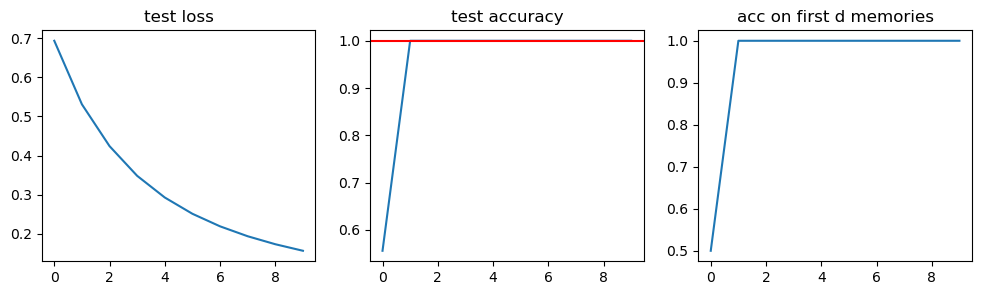

In [523]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title('test loss')
plt.subplot(1, 3, 2)
plt.plot(accs)
plt.axhline(y=star_acc, color='r', linestyle='-')
plt.title('test accuracy')
plt.subplot(1, 3, 3)
plt.plot(accs_start)
plt.title('acc on first d memories')

Text(0.5, 1.0, 'acc on first d mem')

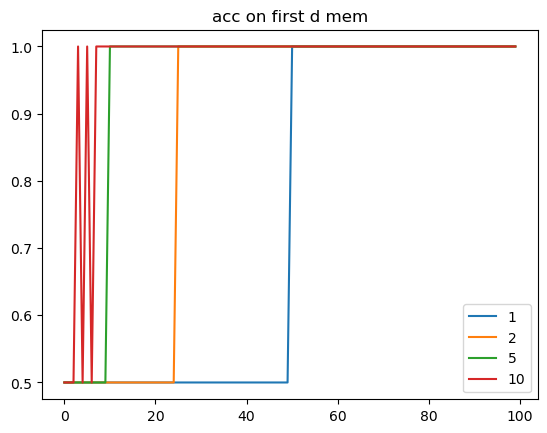

In [557]:
for lr in res:
    plt.plot(res[lr]['accs_start'], label=lr)
plt.legend()
plt.title('acc on first d mem')

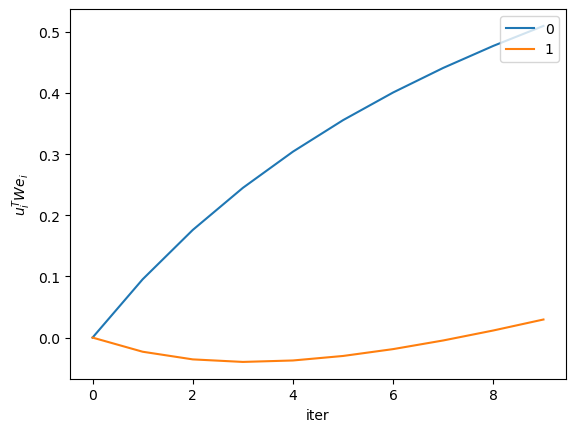

In [418]:
# for i in range(7, 15):
#     plt.plot(all_accs[:,d+i], label=i)
# # plt.legend()
from itertools import chain
for i in chain(range(n)):
    plt.plot(all_scores[:30,i], label=i)
plt.xlabel('iter')
plt.ylabel('$u_i^T W e_i$')
plt.legend(loc='upper right')

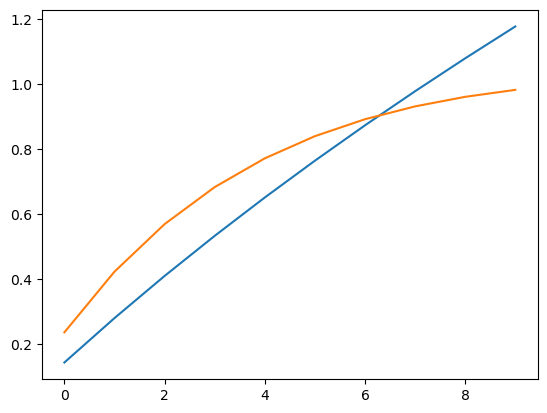

In [419]:
plt.plot(progress[:20])
plt.plot(progress_orth[:20])

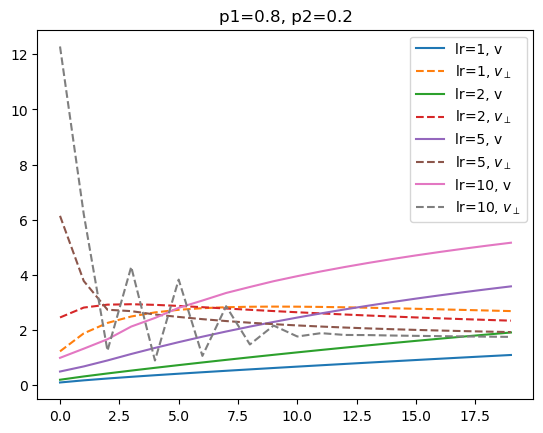

In [558]:
for lr, dd in res.items():
    plt.plot(dd['progress'][:20], label=f"lr={lr}, v")
    plt.plot(dd['progress_orth'][:20], '--', label=f"lr={lr}, " + r"$v_{\perp}$")
#     plt.plot(np.log(np.arange(1, 11)) + np.log(lr))
plt.title(f"p1={proba[0]:.1f}, p2={proba[1]:.1f}")
plt.legend()

Text(0, 0.5, 'lr*sharpness/2')

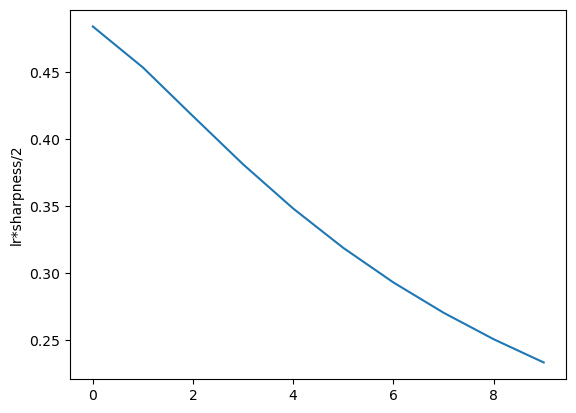

In [522]:
plt.plot(eigenvals_pop[:20])
plt.ylabel('lr*sharpness/2')

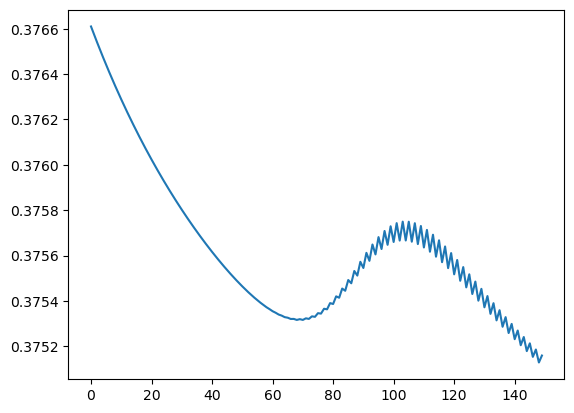

In [25]:
plt.plot(losses[200:350])
# plt.xlim(300, 310)

$W^* = \sum_j 1\{j \leq d\} u_j e_j^T$

$\sum_j \ell(\langle W, u_j e_j^\top\rangle)$

In [40]:
r = 3
(model.UT[:,torch.arange(r)] @ model.E[torch.arange(r)]).shape

torch.Size([5, 5])

In [9]:
model.E[0], model.E[1], model.UT[:,0], model.UT[:,1]

(tensor([0.3264, 0.1890], dtype=torch.float64),
 tensor([0.3782, 0.5723], dtype=torch.float64),
 tensor([ 0.7851, -1.1949], dtype=torch.float64),
 tensor([-0.6993,  0.6774], dtype=torch.float64))

In [301]:
model.UT

AttributeError: 'AssociativeMemory' object has no attribute 'U'